In [ ]:
# importing libraries and data
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch import nn
torch.manual_seed(42)
import time

start_time = time.time()

Data = pd.read_csv("heart_data.csv")

**Data Exploration**

---



In [ ]:
# gives us a brief look at the first few rows of the data
Data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
# gives us some key statistics for numerical columns; including count, mean, and standard deviation for the continous variables
Data[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].describe().round(1)

,age,trestbps,chol,thalach,oldpeak
count,303.0,303.0,303.0,303.0,303.0
mean,54.4,131.6,246.3,149.6,1.0
std,9.1,17.5,51.8,22.9,1.2
min,29.0,94.0,126.0,71.0,0.0
25%,47.5,120.0,211.0,133.5,0.0
50%,55.0,130.0,240.0,153.0,0.8
75%,61.0,140.0,274.5,166.0,1.6
max,77.0,200.0,564.0,202.0,6.2


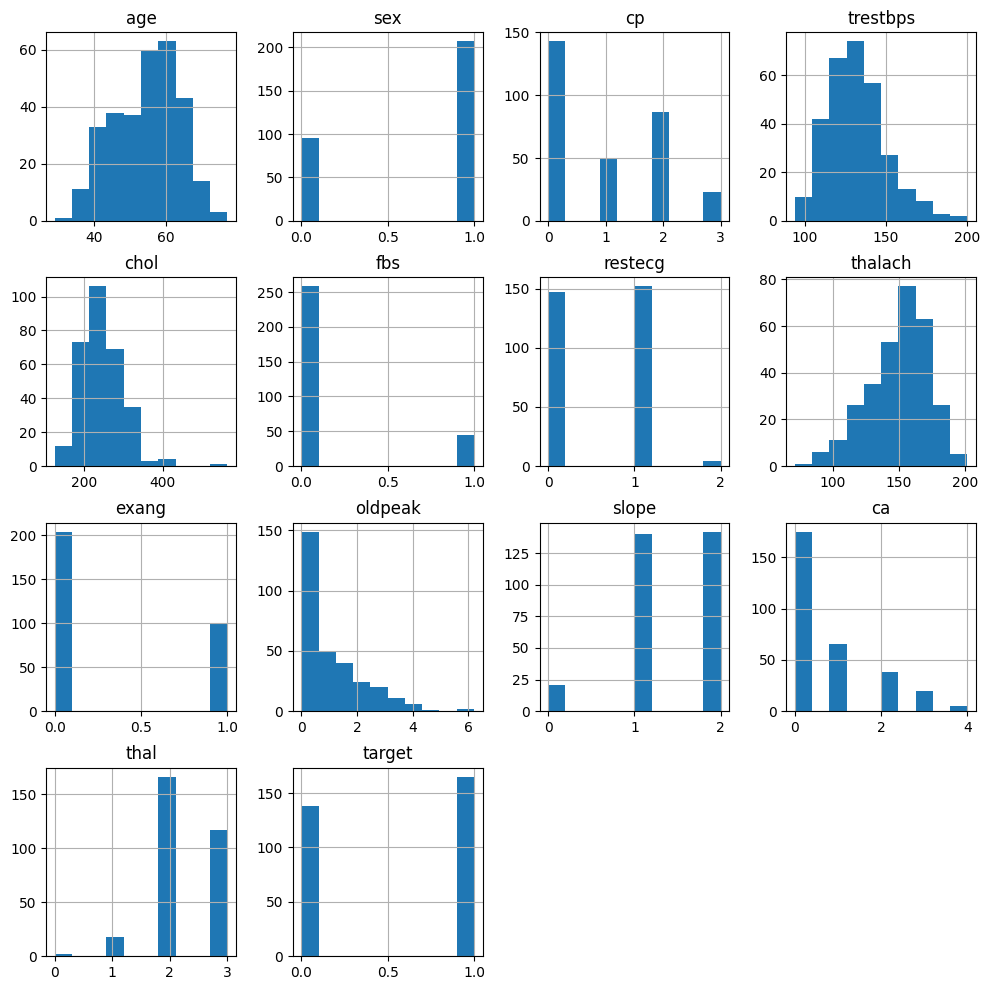

In [ ]:
# gives us a visual representation of the frequency for attributes using histograms
Data.hist(figsize=(12,12));

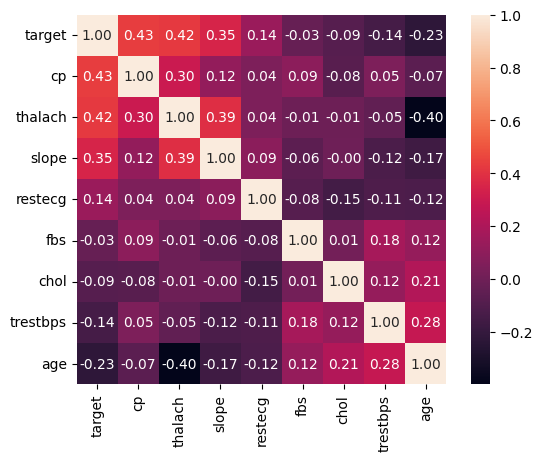

In [ ]:
# gives us a visual representation of top 8 attributes by their correlation to "target" via a correlation matrix
k = 9 #number of variables for heatmap
cols = Data.corr().nlargest(k, 'target')['target'].index
cm = np.corrcoef(Data[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

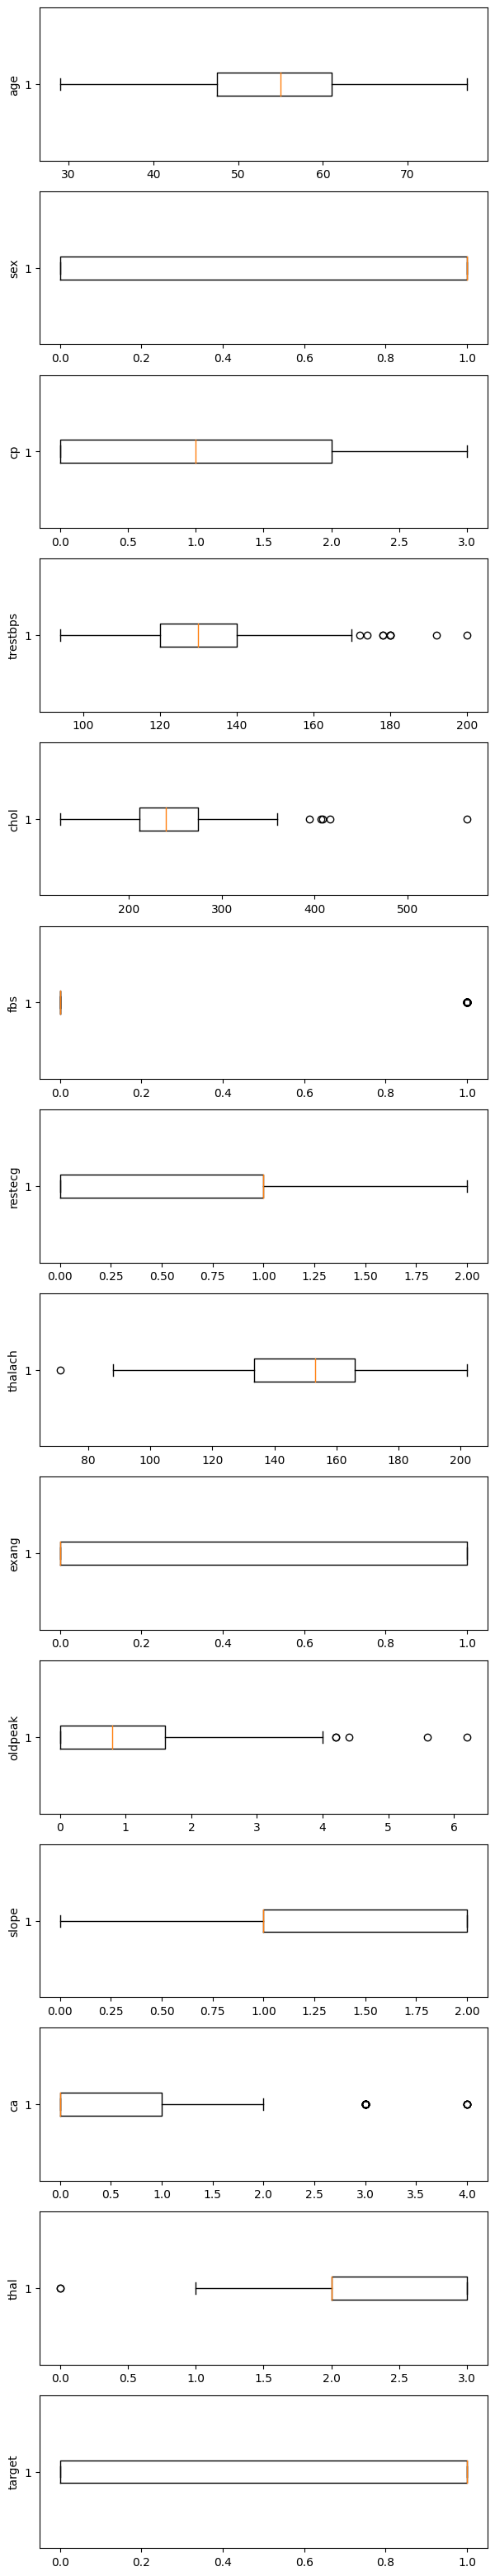

In [ ]:
# gives us overview of outliers using box plots
fig, axs = plt.subplots(14,1, figsize=(7,40))
i = 0
for col in Data.columns:
    axs[i].boxplot(Data[col], vert=False)
    axs[i].set_ylabel(col)
    i+=1
plt.show()

**Data Preprocessing**

---



In [ ]:
# our first step will be to check for "unknown" or null values
Data.isnull().sum()
# since there are none, no action is required

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Outlier detection & removal

In [ ]:
# based on the attributes with outliers highlighted by the box plots, we will now use this function to remove those outliers
def remove_outliers(df, column, distance=1.8):
    q1, q3 = np.percentile(df[column], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (distance * iqr)
    upper_bound = q3 + (distance * iqr)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

columns = ['trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal']  # list of columns to clean
clean_data = Data.copy()  # Start with a copy of the original Data

# apply the function iteratively to each column
for column in columns:
    clean_data = remove_outliers(clean_data, column)

# clean_data now has outliers removed from all specified columns

Data = clean_data.copy()

print("New Shape: ", Data.shape)

New Shape:  (264, 14)


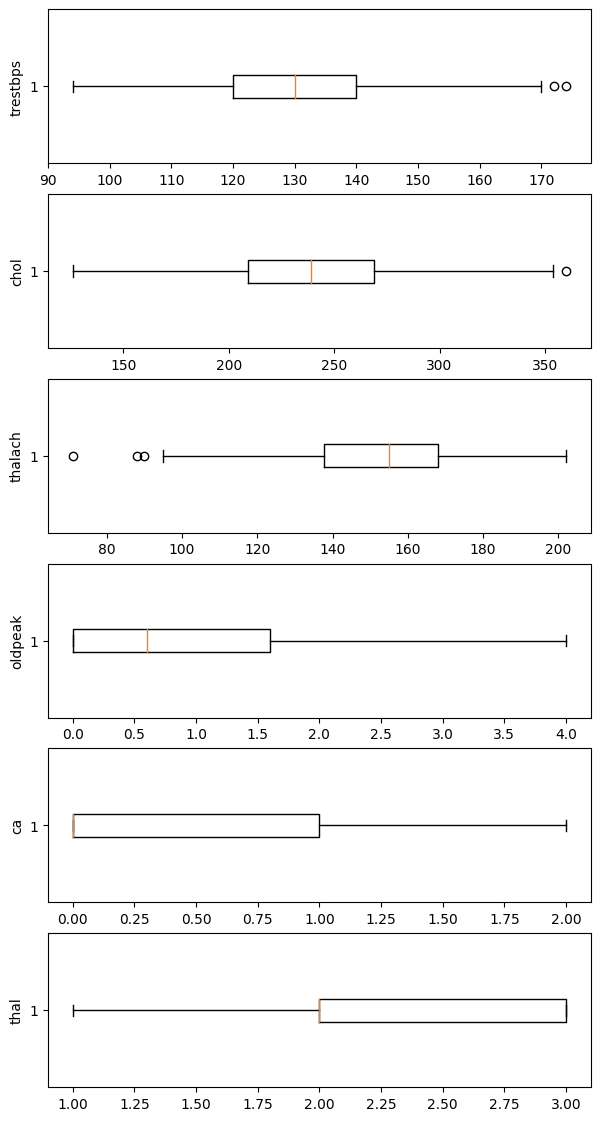

In [ ]:
# check the box plots of the columns which we removed outliers from, it is now much cleaner
fig, axs = plt.subplots(6,1, figsize=(7,14))
i = 0
for col in columns:
    axs[i].boxplot(Data[col], vert=False)
    axs[i].set_ylabel(col)
    i+=1
plt.show()

Normalization

In [ ]:
# min max normalization
scaler = MinMaxScaler()
d = scaler.fit_transform(Data)
Data = pd.DataFrame(d, columns=Data.columns)

Preparing data for training and testing

In [ ]:
# defining target, note that the attributes are selected based on the correlation matrix from earlier
all_y = Data['target']
all_X = Data[cols.drop('target')]

In [ ]:
# turn data into tensors
all_X = all_X.to_numpy()
all_y = all_y.to_numpy()

all_X = torch.from_numpy(all_X).type(torch.float)
all_y = torch.from_numpy(all_y).type(torch.float)

In [ ]:
# 70% training set and 30% test set
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y , test_size=0.3, random_state=42)

print("Length of Training Set:", len(X_train))
print("Length of Test Set:", len(X_test))

Length of Training Set: 184
Length of Test Set: 80


**Building A Neural Network Classifier**

---

Parameter variables (change for sensitivity analysis)

---



In [ ]:
# define the activation functions
activation_functions = {
    "relu": nn.ReLU(),
    "sigmoid": nn.Sigmoid(),
    "tanh": nn.Tanh(),
}

# parameter variables (change for sensitivity analysis)
hyperparameters = {
    "epochs": 300,  # change this for different number of epochs
    "layer_sizes": [5, 8],  # adjust the number and size of layers here. for example [10, 8, 10] would create 3 hidden layers with 10, 8, and 10 neurons respectively
    "activation": "relu",  # change the name to use different activation functions
    "learning_rate": 0.1, # change if needed, default 0.1
    "input_size": len(cols) - 1, # do not change
    "output_size": 1,  # do not change

}

Creating classifier

In [ ]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size, activation):
        super(HeartDiseaseModel, self).__init__()
        layers = []
        current_size = input_size

        for next_size in layer_sizes:
            layers.append(nn.Linear(current_size, next_size))
            layers.append(activation_functions[activation])
            current_size = next_size

        # output layer
        layers.append(nn.Linear(layer_sizes[-1], output_size))

        self.layer_stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer_stack(x)

heart_model = HeartDiseaseModel(input_size=hyperparameters["input_size"],
                                layer_sizes=hyperparameters["layer_sizes"],
                                output_size=hyperparameters["output_size"],
                                activation=hyperparameters["activation"])
print(heart_model)

HeartDiseaseModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=8, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [ ]:
# binary cross entropy for loss
loss_fn = nn.BCEWithLogitsLoss()

# initialize optimizer
optimizer = torch.optim.SGD(params=heart_model.parameters(), lr=hyperparameters["learning_rate"])

Training

In [ ]:
# training loop

y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

for epoch in range(hyperparameters["epochs"]):
    # 1. Forward pass
    y_logits = heart_model(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

**Testing the Model**

In [ ]:
# test
heart_model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(heart_model(X_test))).squeeze()

Metrics

In [ ]:
# calculate the confusion matrix

conf_matrix = confusion_matrix(y_test, y_preds)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

In [ ]:
# calculate accuracy, precision, and recall
accuracy = (TP + TN) / (TP + TN + FP + FN)
auc = roc_auc_score(y_true = y_test, y_score = y_preds)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
end_time = time.time()

# print the metrics
print("Confusion Matrix:\n", conf_matrix)
print("")
print("Accuracy:", round(accuracy, 2))
print("AUC:", round(auc, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))

duration = end_time - start_time
print("Execution Time:", round(duration), " seconds")

Confusion Matrix:
 [[24 10]
 [ 6 40]]

Accuracy: 0.8
AUC: 0.79
Precision: 0.8
Recall: 0.87
Execution Time: 10  seconds
